In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import h5py
from sklearn.preprocessing import normalize
import tensorflow as tf
from imageio import imread #HWC
from torch.optim import lr_scheduler
import time
from torch import optim


%matplotlib inline


In [2]:
gpu_is_avail = torch.cuda.is_available()
if not gpu_is_avail:
     print('CUDA is NOT available.')
else:
     print('CUDA is available. ')

CUDA is available. 


#Лабораторная работа №1 Wool & Cloud Classification

**Создание датасета, найти готовый не удалось, видимо никто не занимался этим**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [334]:
cd /content/gdrive/'My Drive'/DataScience/Balanced_Dataset

/content/gdrive/My Drive/DataScience/Balanced_Dataset


In [355]:
path =  os.getcwd()
path_wool = path + '/wool'
path_cloud = path + '/cloud'

In [356]:
labels = []

for img in os.listdir(path_wool):
    labels.append((img, 'wool', 0 , path_wool + '/' + img))

for img in os.listdir(path_cloud):
    labels.append((img, 'cloud', 1 , path_cloud + '/' + img))

labels = pd.DataFrame(labels, columns=['Name', 'Label', 'N_Label', 'Path'])
labels.to_csv('labels.csv', index=False)

In [357]:
csv_file = 'labels.csv'
labels = pd.read_csv(csv_file)

In [358]:
labels

Name  Label  N_Label                                               Path
0    27.jpg   wool        0  /content/gdrive/My Drive/DataScience/Balanced_...
1    24.jpg   wool        0  /content/gdrive/My Drive/DataScience/Balanced_...
2    26.jpg   wool        0  /content/gdrive/My Drive/DataScience/Balanced_...
3    49.jpg   wool        0  /content/gdrive/My Drive/DataScience/Balanced_...
4    54.jpg   wool        0  /content/gdrive/My Drive/DataScience/Balanced_...
..      ...    ...      ...                                                ...
107  53.jpg  cloud        1  /content/gdrive/My Drive/DataScience/Balanced_...
108  11.jpg  cloud        1  /content/gdrive/My Drive/DataScience/Balanced_...
109   8.jpg  cloud        1  /content/gdrive/My Drive/DataScience/Balanced_...
110   5.jpg  cloud        1  /content/gdrive/My Drive/DataScience/Balanced_...
111  32.jpg  cloud        1  /content/gdrive/My Drive/DataScience/Balanced_...

[112 rows x 4 columns]

##**Dataset**

**Некоторые картинки имеют разные размерности, то есть вместо Height_Width_Channel, Channel_Height_Width**

**ВСЕГО в датасете 112 картинок (56 тех и тех) , 100 ушло в train, 12 для test, но будут проводиться еще доп. тесты, в частности есть дополнительно еще 24 облака и несколько картинок с ватой**

(768, 1024, 3)


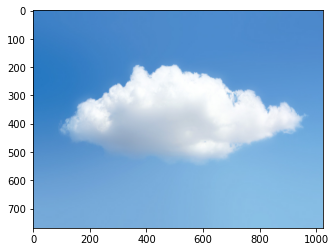

In [347]:
image = imread(labels.iloc[101, 3])
h, w, c = image.shape
print(image.shape)
plt.imshow(image)

(3, 331, 330)
/content/gdrive/My Drive/DataScience/Balanced_Dataset/wool/8.jpg


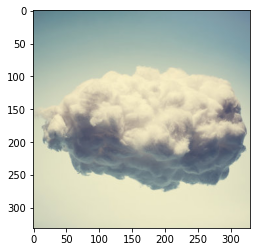

In [345]:
image = imread(labels.iloc[3, 3])
h, w, c = image.shape

print(image.shape)
print(labels.iloc[44, 3])
plt.imshow(image.transpose(1,2,0))

**На синем фоне ваты не так много, сложно такие найти, для усложнения задачи можно подавать в сеть черно-белые фото, но в pre-trained model как я понял нельзя измнить кол-во каналов, так каr они обучались на RGB, поэтому для pre-trained модели оставим цветные**

In [16]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [359]:
class Train(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.samples = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_name = self.samples.iloc[idx, 0]
        labels = self.samples.iloc[idx, 1]
        n_labels = self.samples.iloc[idx, 2]
        path_to_image = self.samples.iloc[idx, 3]
        image = imread(path_to_image)
        h, w, c = image.shape
        if c > 3:
          image = image.transpose(1,2,0)
        #pixels = np.array(image)
        #pixels = normalize(pixels)
        #pixels = torch.from_numpy(pixels)
        #pixels = image
        if self.transform:
            image = self.transform(image)
        #sample = {'image': pixels, 'label': n_labels} 
        #image = pixels   
        labels = n_labels

        return [image, labels]

**Resize для каждой до 224х224**

In [360]:
train = Train(csv_file='labels.csv', 
              root_dir='', 
              transform=transforms.Compose([
                                               transforms.ToPILImage(),
                                               transforms.Resize((224,224)),
                                               #transforms.Grayscale(1),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5,), (0.5,))
                                           ])
             )

In [366]:
train_loader = DataLoader(train, batch_size=4,shuffle=True, num_workers=0)

In [363]:
train[44][0].shape

torch.Size([3, 224, 224])

**Как выглядит батч**

0 torch.Size([4, 3, 224, 224]) tensor([1, 0, 1, 0])
1 torch.Size([4, 3, 224, 224]) tensor([0, 1, 1, 0])
2 torch.Size([4, 3, 224, 224]) tensor([0, 1, 0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([4, 3, 224, 224]) tensor([0, 1, 0, 0])
4 torch.Size([4, 3, 224, 224]) tensor([0, 0, 0, 1])


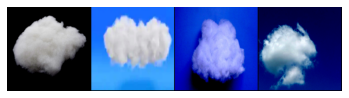

In [369]:
def show_batch(sample_batched):
    images_batch, labels = sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(), sample_batched[1] )
    if i_batch == 4:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
    

In [370]:
full_dataset = train
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [371]:
len(train_dataset), len(test_dataset)

(100, 12)

In [374]:
trainloader = DataLoader(train_dataset,batch_size=4,
                        shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset,batch_size=4,
                        shuffle=False, num_workers=0)

##**Pretrained Model**

**ВЫБРАНА ResNet152 и добавлен выходной слой**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model.to(device)

In [378]:
epochs = 25
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'woolcloud_model_112.pth')

Epoch 1/25.. Train loss: 0.939.. Test loss: 0.655.. Test accuracy: 0.500
Epoch 1/25.. Train loss: 0.592.. Test loss: 0.374.. Test accuracy: 1.000
Epoch 2/25.. Train loss: 0.615.. Test loss: 0.342.. Test accuracy: 1.000
Epoch 2/25.. Train loss: 0.364.. Test loss: 0.272.. Test accuracy: 1.000
Epoch 2/25.. Train loss: 0.312.. Test loss: 0.348.. Test accuracy: 0.750
Epoch 3/25.. Train loss: 0.230.. Test loss: 0.238.. Test accuracy: 0.917
Epoch 3/25.. Train loss: 0.365.. Test loss: 0.161.. Test accuracy: 1.000
Epoch 4/25.. Train loss: 0.323.. Test loss: 0.176.. Test accuracy: 1.000
Epoch 4/25.. Train loss: 0.276.. Test loss: 0.256.. Test accuracy: 0.833
Epoch 4/25.. Train loss: 0.615.. Test loss: 1.630.. Test accuracy: 0.417
Epoch 5/25.. Train loss: 0.642.. Test loss: 0.460.. Test accuracy: 0.750
Epoch 5/25.. Train loss: 0.383.. Test loss: 0.566.. Test accuracy: 0.750
Epoch 6/25.. Train loss: 0.621.. Test loss: 0.200.. Test accuracy: 0.917
Epoch 6/25.. Train loss: 0.315.. Test loss: 0.149..

In [489]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('woolcloud_model_112.pth')
model.eval()
test_transforms = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.Resize((224,224)),
                                       #transforms.Grayscale(1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                     ])

In [380]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    if index==0:
      print("IT`S WOOL")
    elif index==1:
      print("IT`S CLOUD")  

**Тест на облаках, которые он не видел**

IT`S CLOUD
0


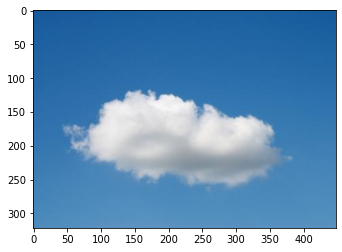

IT`S CLOUD
1


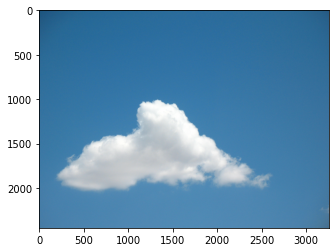

IT`S CLOUD
2


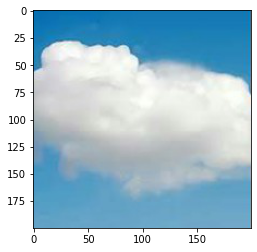

IT`S CLOUD
3


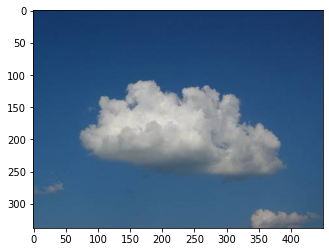

IT`S CLOUD
4


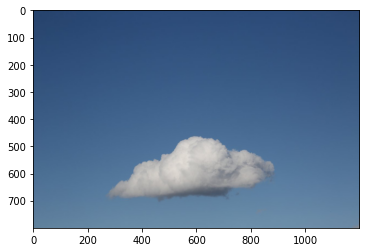

IT`S CLOUD
5


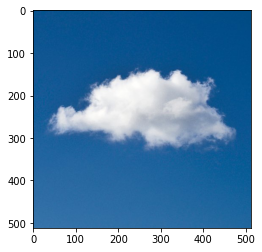

IT`S CLOUD
6


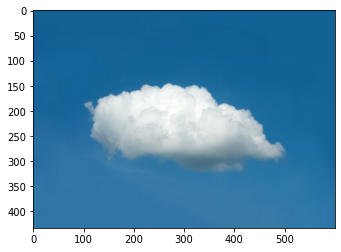

IT`S CLOUD
7


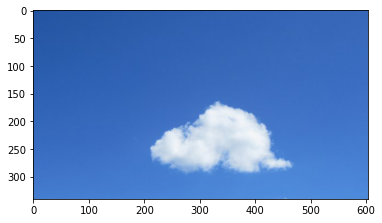

IT`S CLOUD
8


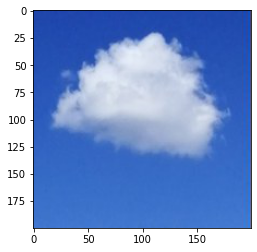

IT`S CLOUD
9


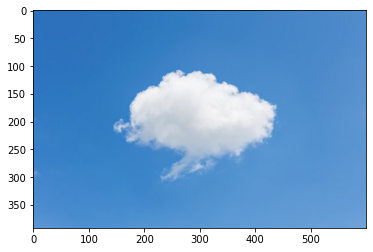

IT`S CLOUD
10


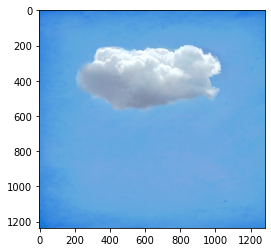

IT`S CLOUD
11


IT`S CLOUD
12


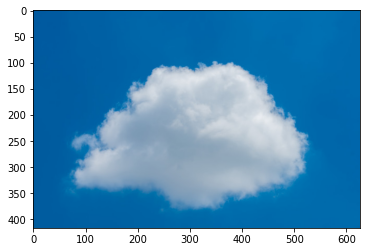

IT`S CLOUD
13


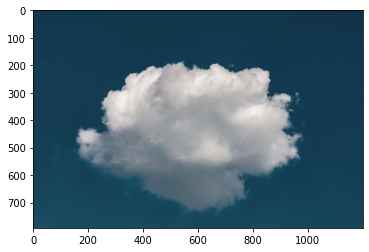

IT`S CLOUD
14


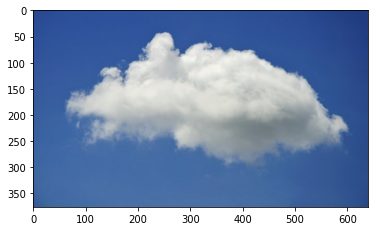

IT`S CLOUD
15


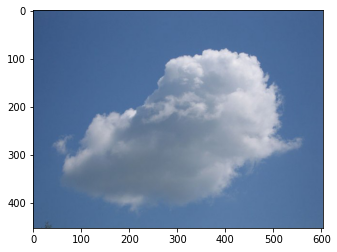

IT`S CLOUD
16


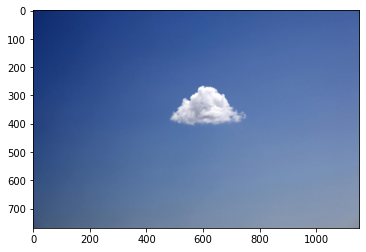

IT`S CLOUD
17


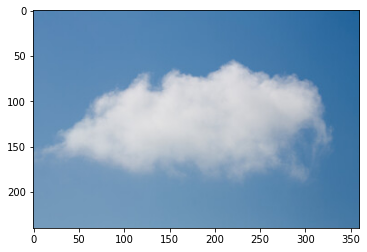

IT`S CLOUD
18


IT`S CLOUD
19


IT`S CLOUD
20


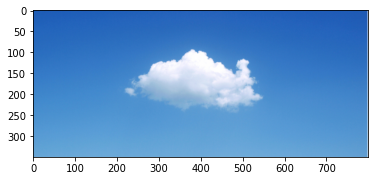

IT`S CLOUD
21


IT`S WOOL
22


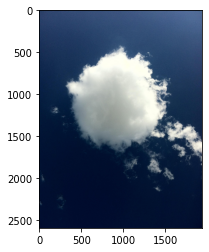

IT`S CLOUD
23


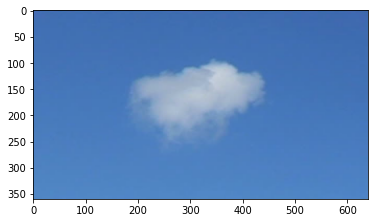

In [459]:
for i in range(56,80):
  image = imread('/content/gdrive/My Drive/DataScience/Dataset/cloud/'+str(i+1)+'.jpg')
  predict_image(image)
  print(i-56)
  plt.pause(0.1)
  plt.imshow(image)
  plt.pause(0.1)

**ИЗ 24 картинок одна определилась неправильно, то есть точности около 90-95% , так показывает и тестовый из 12**

**Проверим на доп.картинках ваты**

In [460]:
image = imread('/content/gdrive/My Drive/DataScience/Balanced_Dataset/w1.jpg')
plt.imshow(image.transpose(1,2,0))
predict_image(image)

IT`S WOOL


IT`S WOOL


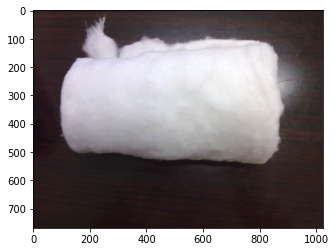

In [461]:
image = imread('/content/gdrive/My Drive/DataScience/Balanced_Dataset/w2.jpg')
plt.imshow(image)
predict_image(image)

IT`S WOOL


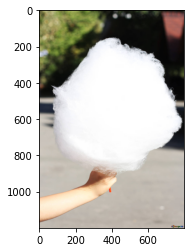

In [490]:
image = imread('/content/gdrive/My Drive/DataScience/Balanced_Dataset/w3.jpg')
plt.imshow(image)
predict_image(image)

In [491]:
image = imread('/content/gdrive/My Drive/DataScience/Balanced_Dataset/w4.jpg')
plt.imshow(image)
predict_image(image)

IT`S WOOL


**4 из 4**

##**Own architecture**

**Здесь уже будем подавать картинки с одним каналом (черно-белые), так более честно что ли :D**

In [382]:
class MyNET(nn.Module):
    def __init__(self):
        super(MyNET, self).__init__() 
        hid1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=56, kernel_size=2, padding=2),
            nn.BatchNorm2d(num_features=56),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hid2 = nn.Sequential(
            nn.Conv2d(in_channels=56, out_channels=64, kernel_size=2, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2) 
        )
        hid3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hid4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=2, padding=2),
            nn.BatchNorm2d(num_features=160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hid5 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=192, kernel_size=2, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hid6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=2, padding=1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1, padding=0),
            nn.Dropout(0.2)
        )
        hid7 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=2, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        hid8 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=2, padding=1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        hid9 = nn.Sequential(
            nn.Linear(27648, 576),
            nn.ReLU()
        )
        hid10 = nn.Sequential(
            nn.Linear(576, 238),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(238, 2),
            nn.LogSoftmax(dim=1)
        )
        self._features = nn.Sequential(
            hid1,
            hid2,
            hid3,
            hid4,
            hid5,
            hid6,
            hid7,
            hid8
        )
        self._classifier = nn.Sequential(
            hid9,
            hid10
        )
    def forward(self, x): 
        x = self._features(x)
        #print(x.size())
        x = x.view(x.size(0), 27648)
        #print(x.size())
        x = self._classifier(x)
        return x

In [385]:
train = Train(csv_file='labels.csv', 
              root_dir='', 
              transform=transforms.Compose([
                                               transforms.ToPILImage(),
                                               transforms.Resize((224,224)),
                                               transforms.Grayscale(1),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5,), (0.5,))
                                           ])
             )

In [386]:
full_dataset = train
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [401]:
train_loader = DataLoader(train_dataset,batch_size=4,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset,batch_size=4,
                        shuffle=False, num_workers=0)

**Черно-белый батч**

0 torch.Size([4, 1, 224, 224]) tensor([1, 0, 1, 1])
1 torch.Size([4, 1, 224, 224]) tensor([0, 1, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([4, 1, 224, 224]) tensor([1, 1, 1, 1])
3 torch.Size([4, 1, 224, 224]) tensor([0, 1, 0, 0])


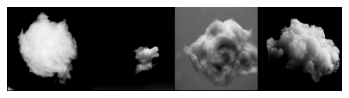

In [402]:
def show_batch(sample_batched):
    images_batch, labels = sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(), sample_batched[1] )
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [435]:
model = MyNET() 
model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adadelta(model.parameters(), lr = 0.1)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
num_epochs = 100
for epoch in range(num_epochs): 
    for i, (pixels, labels) in enumerate(train_loader): 
        
        optimizer.zero_grad() 
        pixels = pixels.to(device)
        labels = labels.to(device)
        
        outputs = model(pixels)#.to(device)
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 
  
        if (i + 1) % 10 == 0: 
            print('Epoch: [% d/% d], Loss: %.4f'
                  % (epoch + 1, num_epochs, loss.item()))
    correct = 0
    total = 0
    for pixels, labels in test_loader:
        labels = labels.cuda() 
        pixels = pixels.cuda() 
        outputs = model(pixels.float()) 
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum() 
  
        print('Accuracy of the model on the 12 test images: % d %%' % ( 
            100 * correct // total))        
            

Epoch: [ 1/ 100], Loss: 0.4841
Epoch: [ 1/ 100], Loss: 0.5918
Accuracy of the model on the 12 test images:  100 %
Accuracy of the model on the 12 test images:  75 %
Accuracy of the model on the 12 test images:  75 %
Epoch: [ 2/ 100], Loss: 0.5353
Epoch: [ 2/ 100], Loss: 0.0961
Accuracy of the model on the 12 test images:  100 %
Accuracy of the model on the 12 test images:  87 %
Accuracy of the model on the 12 test images:  75 %
Epoch: [ 3/ 100], Loss: 3.0812
Epoch: [ 3/ 100], Loss: 0.2310
Accuracy of the model on the 12 test images:  100 %
Accuracy of the model on the 12 test images:  100 %
Accuracy of the model on the 12 test images:  83 %
Epoch: [ 4/ 100], Loss: 0.2172
Epoch: [ 4/ 100], Loss: 0.3678
Accuracy of the model on the 12 test images:  100 %
Accuracy of the model on the 12 test images:  87 %
Accuracy of the model on the 12 test images:  83 %
Epoch: [ 5/ 100], Loss: 0.4014
Epoch: [ 5/ 100], Loss: 0.0463
Accuracy of the model on the 12 test images:  100 %
Accuracy of the model

In [436]:
torch.save(model, 'own_woolcloud_model_last2.pth')

In [462]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('own_woolcloud_model_last2.pth')
model.eval()
test_transforms = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.Resize((224,224)),
                                       transforms.Grayscale(1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                     ])

IT`S CLOUD
0


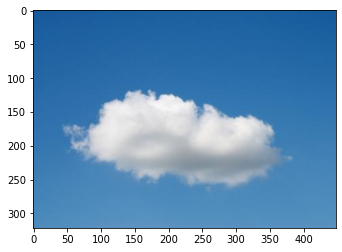

IT`S CLOUD
1


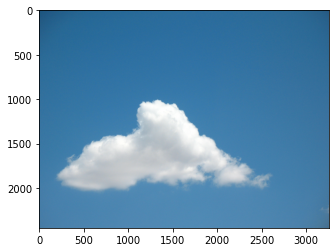

IT`S CLOUD
2


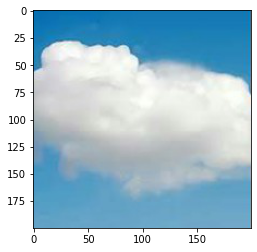

IT`S CLOUD
3


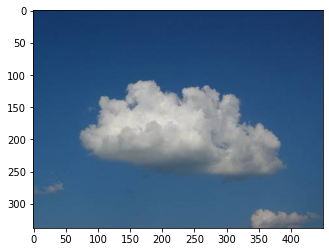

IT`S CLOUD
4


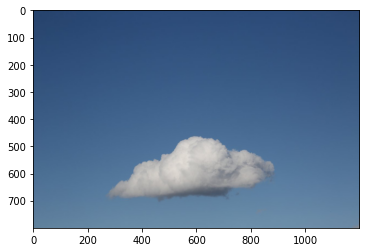

IT`S CLOUD
5


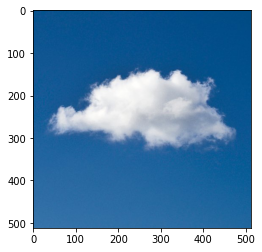

IT`S CLOUD
6


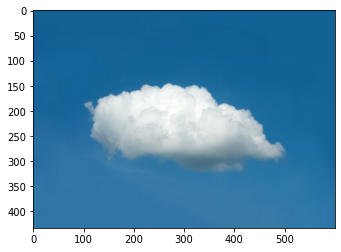

IT`S CLOUD
7


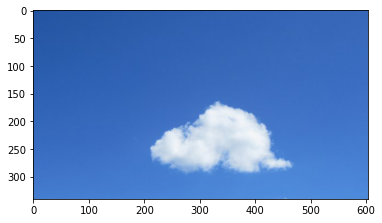

IT`S WOOL
8


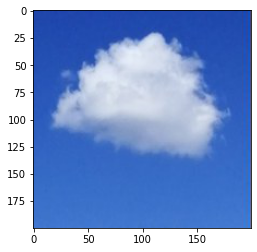

IT`S CLOUD
9


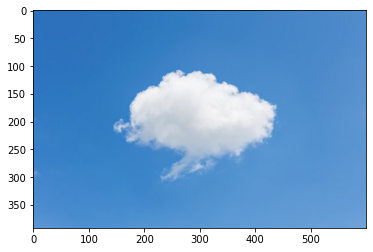

IT`S WOOL
10


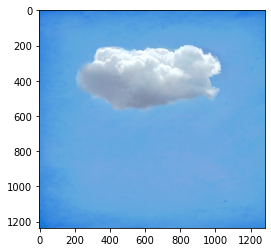

IT`S CLOUD
11


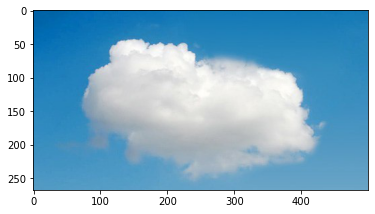

IT`S CLOUD
12


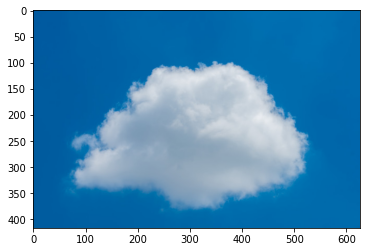

IT`S CLOUD
13


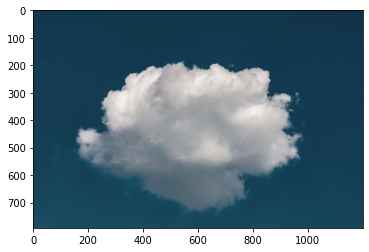

IT`S WOOL
14


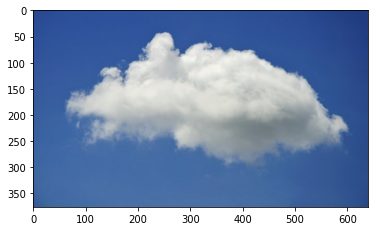

IT`S WOOL
15


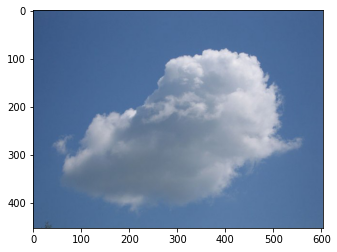

IT`S CLOUD
16


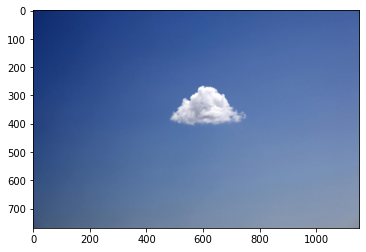

IT`S WOOL
17


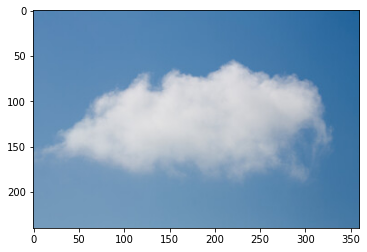

IT`S CLOUD
18


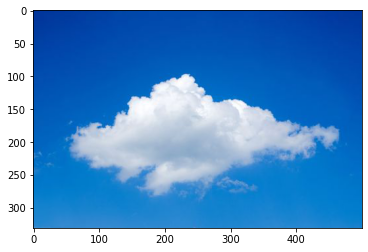

IT`S CLOUD
19


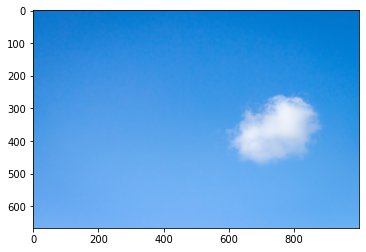

IT`S CLOUD
20


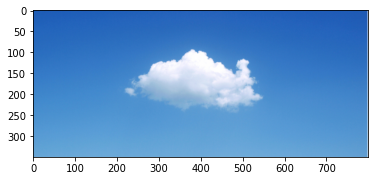

IT`S CLOUD
21


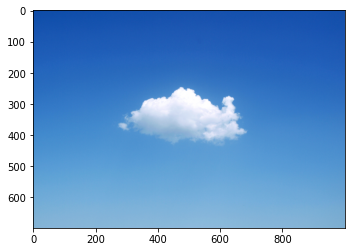

IT`S CLOUD
22


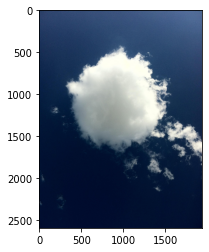

IT`S CLOUD
23


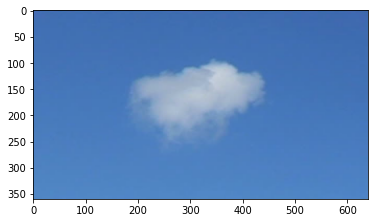

In [481]:
from scipy import misc
for i in range(56,80):
  image = imread('/content/gdrive/My Drive/DataScience/Dataset/cloud/'+str(i+1)+'.jpg')
  predict_image(image)
  print(i-56)
  plt.pause(0.1)
  #image = test_transforms(image)
  plt.imshow(image)
  plt.pause(0.1)

  

**ИЗ 24 картинок 5 определилось неправильно - точность около 80%**

IT`S WOOL


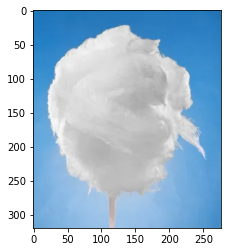

In [483]:
image = imread('/content/gdrive/My Drive/DataScience/Balanced_Dataset/w1.jpg')
plt.imshow(image.transpose(1,2,0))
predict_image(image)

IT`S CLOUD


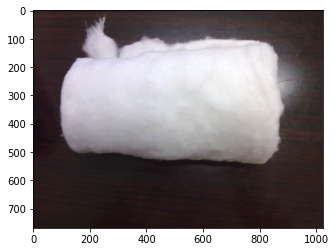

In [484]:
image = imread('/content/gdrive/My Drive/DataScience/Balanced_Dataset/w2.jpg')
plt.imshow(image)
predict_image(image)

IT`S WOOL


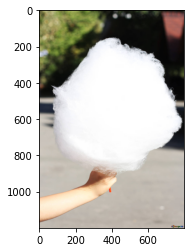

In [485]:
image = imread('/content/gdrive/My Drive/DataScience/Balanced_Dataset/w3.jpg')
plt.imshow(image)
predict_image(image)

IT`S WOOL


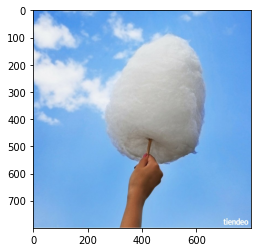

In [488]:
image = imread('/content/gdrive/My Drive/DataScience/Balanced_Dataset/w4.jpg')
plt.imshow(image)
predict_image(image)

**3 из 4 => 75-80%**

In [501]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    #if index==0:
      #print("IT`S WOOL")
   # elif index==1:
     # print("IT`S CLOUD")  

##**Итоги и сравнение скорости и веса :**

**Pre-trained model (woolcloud_model_112.pth)**

Точность: примерно 90-95% с RGB

Вес: 227 MB

In [493]:
device = torch.device("cuda")
model=torch.load('woolcloud_model_112.pth')
model.eval()
test_transforms = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.Resize((224,224)),
                                       #transforms.Grayscale(1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                     ])

In [496]:
times = []
for i in range(56,80):
  image = imread('/content/gdrive/My Drive/DataScience/Dataset/cloud/'+str(i+1)+'.jpg')
  start = time.time()
  predict_image(image)
  end = time.time()
  times.append(end - start)
print("Среднее время работы:", np.mean(times))

Среднее время работы: 0.028771062692006428


**Own model ((own_woolcloud_model_last2.pth)**

Точность:  примерно 80% c черно-белыми**

Вес: 64 MB

In [502]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('own_woolcloud_model_last2.pth')
model.eval()
test_transforms = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.Resize((224,224)),
                                       transforms.Grayscale(1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                     ])

In [503]:
times = []
for i in range(56,80):
  image = imread('/content/gdrive/My Drive/DataScience/Dataset/cloud/'+str(i+1)+'.jpg')
  start = time.time()
  predict_image(image)
  end = time.time()
  times.append(end - start)
print("Среднее время работы:", np.mean(times))

Среднее время работы: 0.009828488032023111
